In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

import warnings
warnings.filterwarnings('ignore')

In [23]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

# Loading position changes to find attacks

There is a need to check if there are real MEV attacks present on the platform. Considering that this option was mentioned in the official documentation it is required to review this option. The only aspect of the Perpetual V2 where MEV attacks can be performed is ```position changes```. This is becuase of the mechanism behind changing position:

1. Perpetual V2 suggests that there are either long or short positions opened. Long position means that trader bought some tokens while short means trader sold some of the tokens. Therefore, each position position change demonstrates "purchase" of the tokens and negative position change covers "sell" of the tokens. This mechanism works by the swap principle and behind those changes there are swaps of virtual tokens;
2. Each swap causes shift of the token price because of the "swap-like" mechanism. Attacker can set a big position change to cause price shift but there are two problems that greatly decrease likelihood of the attacks: considering applied leverage to increase amount of tokens participating in the pool it will be required to make much higher transactions, and entire platform works on the Optimism network with much higher transaction speed and therefore it will take smaller time to process a transaction block (and less time to find "victim" transaction);
3. There are no regulation mechanisms applied to stabilize the price distribution (only funding payments, but they are only supporting shift closer to the real price).

The first step of this MEV attacks detection will be "ignoring" transactions where price changes too heavy because of the system errors.

In [24]:
position_changes_df = pd.read_csv("position_changes.csv")
position_changes_df.drop(columns=["Unnamed: 0"], inplace=True)
position_changes_df["time"] = pd.to_datetime(position_changes_df["timestamp"], unit='s')
position_changes_df["pool_name"] = position_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
position_changes_df.sort_values(by='block_number_log_index', inplace=True)
position_changes_df = position_changes_df.reset_index()
position_changes_df.drop(columns=["base_token", "id", "from_function_signature", "block_number", "index"], inplace=True)
position_changes_df

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
0,0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055178,-2997.000000,3.000000,-3000.000000,0.0,0.055178,54315.297418,54369.667085,54334.893904,515560007,1638001140,2021-11-27 08:19:00,vBTC
1,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729828,-2997.000000,3.000000,-3000.000000,0.0,0.729828,4106.445744,4110.556300,4108.035203,515571005,1638001140,2021-11-27 08:19:00,vETH
2,0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055138,-2997.000000,3.000000,-6000.000000,0.0,0.110316,54354.490389,54389.276112,54374.093942,515582004,1638001140,2021-11-27 08:19:00,vBTC
3,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729264,-2997.000000,3.000000,-6000.000000,0.0,1.459092,4109.624663,4112.146735,4111.214738,515584004,1638001140,2021-11-27 08:19:00,vETH
4,0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055098,-2997.000000,3.000000,-9000.000000,0.0,0.165414,54393.697496,54408.885139,54413.308117,515587004,1638001140,2021-11-27 08:19:00,vBTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371091,0xf2d260d060e194efe9456366a187f8b1bbadede2112a...,0x66465ad392942e78f8147ae565a43f174071822b,-63.016538,1007.767544,1.007768,77543.167127,0.0,-4785.063498,15.992112,16.205254,15.968758,12161192007,1655487520,2022-06-17 17:38:40,vAVAX
3371092,0x70f96597f01dd545840b697b13056240e0b87599cb06...,0x31789f360b9aab20837a35944904deb540533357,-5.821204,1250.535778,1.250536,28511.176773,0.0,-132.045808,214.824254,215.918833,214.596023,12161203007,1655487554,2022-06-17 17:39:14,vBNB
3371093,0x57f2cd5a07c1e96d84b1b1f4b479e0e5e498f1edc445...,0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a,-3419.000000,806.897384,0.806897,806.090487,0.0,-3419.000000,0.236004,0.235768,0.235708,12161205005,1655487554,2022-06-17 17:39:14,vFTM
3371094,0xf26360ff610d3f5db14d31d97a8d0c5158741b3f2268...,0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca,-1220.524515,750.778051,0.750778,74113.308142,0.0,-122785.420591,0.615127,0.603600,0.614201,12161208007,1655487554,2022-06-17 17:39:14,vPERP


The first step in performing effective analysis is to remove transactions where by unknown reasons are placed transactions with no changes applied from both tokens and capitalization perspectives, from the fees perspective. It will allow evade of the errors based on incorrect calculation.

In [25]:
clear_position_changes = position_changes_df.drop(position_changes_df[
    (position_changes_df["exchanged_position_size"] == 0) &
    (position_changes_df["exchanged_position_notional"] == 0) &
    (position_changes_df["fee"] == 0)
].index)

clear_position_changes

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
0,0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055178,-2997.000000,3.000000,-3000.000000,0.0,0.055178,54315.297418,54369.667085,54334.893904,515560007,1638001140,2021-11-27 08:19:00,vBTC
1,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729828,-2997.000000,3.000000,-3000.000000,0.0,0.729828,4106.445744,4110.556300,4108.035203,515571005,1638001140,2021-11-27 08:19:00,vETH
2,0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055138,-2997.000000,3.000000,-6000.000000,0.0,0.110316,54354.490389,54389.276112,54374.093942,515582004,1638001140,2021-11-27 08:19:00,vBTC
3,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729264,-2997.000000,3.000000,-6000.000000,0.0,1.459092,4109.624663,4112.146735,4111.214738,515584004,1638001140,2021-11-27 08:19:00,vETH
4,0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.055098,-2997.000000,3.000000,-9000.000000,0.0,0.165414,54393.697496,54408.885139,54413.308117,515587004,1638001140,2021-11-27 08:19:00,vBTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371091,0xf2d260d060e194efe9456366a187f8b1bbadede2112a...,0x66465ad392942e78f8147ae565a43f174071822b,-63.016538,1007.767544,1.007768,77543.167127,0.0,-4785.063498,15.992112,16.205254,15.968758,12161192007,1655487520,2022-06-17 17:38:40,vAVAX
3371092,0x70f96597f01dd545840b697b13056240e0b87599cb06...,0x31789f360b9aab20837a35944904deb540533357,-5.821204,1250.535778,1.250536,28511.176773,0.0,-132.045808,214.824254,215.918833,214.596023,12161203007,1655487554,2022-06-17 17:39:14,vBNB
3371093,0x57f2cd5a07c1e96d84b1b1f4b479e0e5e498f1edc445...,0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a,-3419.000000,806.897384,0.806897,806.090487,0.0,-3419.000000,0.236004,0.235768,0.235708,12161205005,1655487554,2022-06-17 17:39:14,vFTM
3371094,0xf26360ff610d3f5db14d31d97a8d0c5158741b3f2268...,0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca,-1220.524515,750.778051,0.750778,74113.308142,0.0,-122785.420591,0.615127,0.603600,0.614201,12161208007,1655487554,2022-06-17 17:39:14,vPERP


During Uniswap V2 and similar platforms analysis was discovered that there is an option of protecting pools against MEV attacks via application of the slippage with around 5% threshold. In the current case to find MEV attacks will be performed filtering, ignoring all the cases where difference is smaller than 5%.

In [26]:
eth_clear_position_changes = clear_position_changes[clear_position_changes["pool_name"] == "vETH"]
eth_clear_position_changes["price_pct"] = abs(eth_clear_position_changes["swapped_price"].pct_change(fill_method='ffill')) * 100
eth_clear_position_changes = eth_clear_position_changes.reset_index()
eth_clear_position_changes.drop(columns=["index"], inplace=True)
eth_clear_position_changes

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name,price_pct
0,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729828,-2997.000000,3.000000,-3000.000000,0.000000,0.729828,4106.445744,4110.556300,4108.035203,515571005,1638001140,2021-11-27 08:19:00,vETH,NaN
1,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729264,-2997.000000,3.000000,-6000.000000,0.000000,1.459092,4109.624663,4112.146735,4111.214738,515584004,1638001140,2021-11-27 08:19:00,vETH,0.077413
2,0x9b6ea00e0e7e7610105cf3eb2f97727c93103a9816b6...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.728700,-2997.000000,3.000000,-9000.000000,0.000000,2.187792,4112.804813,4113.737171,4114.395503,515589004,1638001140,2021-11-27 08:19:00,vETH,0.077383
3,0x47357bec5ee7101b57f457be5135c91a9c7133cc82bb...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.728137,-2997.000000,3.000000,-12000.000000,0.000000,2.915928,4115.986193,4115.327606,4117.577498,515594004,1638001140,2021-11-27 08:19:00,vETH,0.077353
4,0xe505626b5d32532a83c5d5bc30c7d44bb1b00f01f113...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.727574,-2997.000000,3.000000,-15000.000000,0.000000,3.643502,4119.168803,4116.918041,4120.760723,515609004,1638001140,2021-11-27 08:19:00,vETH,0.077323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316402,0xfce5db9fa966b4d829ff1b97a9ab48dd9c71369b22c0...,0x91d46a68324991f2e96f121317b642a8d4179190,6.249075,-6748.274038,6.755029,411625.996362,8.985862,-380.289158,1079.883745,1082.402661,1080.350665,12161025008,1655487397,2022-06-17 17:36:37,vETH,0.072761
316403,0x12e03c7f9141f3b5244c766166556109aac6f79f8583...,0x91d46a68324991f2e96f121317b642a8d4179190,-4.164000,4497.284425,4.497284,416118.783502,0.000000,-384.453158,1080.039493,1082.365367,1079.728411,12161068007,1655487475,2022-06-17 17:37:55,vETH,0.014423
316404,0x8a60898e97444b4a31b638910f2b035fe1b08524acbf...,0x91d46a68324991f2e96f121317b642a8d4179190,-0.000840,0.907243,0.000907,416119.689838,0.000000,-384.453998,1079.728348,1082.365359,1079.728286,12161087007,1655487490,2022-06-17 17:38:10,vETH,0.028809
316405,0x103c07b0e83472c600f0279780695ace46b60a0278a7...,0x3205dbab7b8d704ed05bc72234178d61058c10ca,-3.700000,3993.972466,3.993972,5309.805821,0.000000,-4.920000,1079.452018,1079.228825,1079.175821,12161091006,1655487490,2022-06-17 17:38:10,vETH,0.025593


In [27]:
eth_clear_position_changes[eth_clear_position_changes["price_pct"] > 5].index

Int64Index([  3668,   3669,   3723,   3724,   3730,   3731,   3828,   3829,
              3880,   3881,
            ...
            306599, 306600, 306978, 306979, 307337, 307338, 309750, 309751,
            309960, 309961],
           dtype='int64', length=1198)

In [28]:
indexes_outside_threshold = eth_clear_position_changes[eth_clear_position_changes["price_pct"] > 5].index
mev_eth_attacks = eth_clear_position_changes.loc[indexes_outside_threshold]
prev_mev_eth_attacks = eth_clear_position_changes.loc[indexes_outside_threshold - 1]
next_mev_eth_attacks = eth_clear_position_changes.loc[indexes_outside_threshold + 1]

mevs_eth_df = pd.concat([mev_eth_attacks, prev_mev_eth_attacks, next_mev_eth_attacks])
mevs_eth_df = mevs_eth_df.sort_index()
mevs_eth_df.drop_duplicates(inplace=True)
mevs_eth_df.tail(20)

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name,price_pct
306598,0x8c40e1482208a04200f749b8a463ecad7a4fcd802c5e...,0x91d46a68324991f2e96f121317b642a8d4179190,4.277278,-5244.159733,5.249409,222366.734800,17.505838,-180.584730,1226.050609,1231.370639,1226.436320,11961285005,1655332691,2022-06-15 22:38:11,vETH,0.031540
306599,0xf847c9db29cdb2a16b6095872617f85e14699835ce34...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,-92.108150,103748.384555,0.000000,103748.384555,0.000000,-92.108150,1126.375723,1126.375723,1226.436320,11961355009,1655332782,2022-06-15 22:39:42,vETH,8.129753
306600,0x2de40b608b92d1b032a955856a457152ff4678f5e232...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,92.108150,-113799.373970,113.913287,0.000000,-10164.902702,0.000000,1235.497331,0.000000,1244.625285,11961483008,1655332812,2022-06-15 22:40:12,vETH,9.687851
306601,0xb64c00ee416912171446cd8051b43a0a16c960fcdc1a...,0x9b0c54e6eff8979b3a8fbb129313f2864c07e6dd,-8.047781,10010.010010,10.010010,10000.000000,0.000000,-8.047781,1243.822372,1242.578550,1243.019978,11961493005,1655332827,2022-06-15 22:40:27,vETH,0.673821
306977,0x4d4af705c416caa739dd7b07fb9cb860c4440db828c0...,0x91d46a68324991f2e96f121317b642a8d4179190,3.304356,-4125.408645,4.129538,210685.509002,-41.806756,-170.309600,1248.475883,1237.073595,1248.806100,11970867008,1655338424,2022-06-16 00:13:44,vETH,0.055304
306978,0xee000956c3ba7b92c6d3e9b914207d43c1ea8d242ea3...,0x1b65733bb3c8e5296858f1eb8cdd098aba712686,0.070438,-100.000000,0.000000,-100.000000,0.000000,0.070438,1419.684968,1419.684968,1248.806100,11970883008,1655338424,2022-06-16 00:13:44,vETH,13.713448
306979,0x889d6a9508668a8b559a83945095e005769e8983666b...,0x91d46a68324991f2e96f121317b642a8d4179190,-0.001400,1.748341,0.001748,210687.255595,0.000000,-170.311000,1248.805960,1237.073681,1248.805820,11970926007,1655338440,2022-06-16 00:14:00,vETH,12.036403
306980,0x1fe39228efc92096c0ffa7e60d86597cfa0099885120...,0x91d46a68324991f2e96f121317b642a8d4179190,-2.199198,2745.888326,2.745888,213430.398033,0.000000,-172.510198,1248.586026,1237.204526,1248.366272,11970933004,1655338440,2022-06-16 00:14:00,vETH,0.017611
307336,0xd778a3fc475291f03c41a756d1366db0fbfbacf79ff9...,0x91d46a68324991f2e96f121317b642a8d4179190,3.048220,-3746.350280,3.750100,278225.034106,21.904114,-224.838296,1229.028910,1237.445039,1229.324699,11978532008,1655344166,2022-06-16 01:49:26,vETH,0.019463
307337,0xe6a60af38c79c66128599065255a2445c0f5a1fa49ad...,0xb335d18843137b21db0c9ebc23e7ed9f0d33f14d,0.051460,-83.794467,0.000000,-83.794467,0.000000,0.051460,1628.335121,1628.335121,1229.324699,11978543008,1655344166,2022-06-16 01:49:26,vETH,32.489570


In [29]:
mevs_eth_df[(mevs_eth_df["exchanged_position_size"] == mevs_eth_df["position_size_after"]) |
            (mevs_eth_df["exchanged_position_size"] == 0)]

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name,price_pct
3668,0xa7a033ebca65e6f4abc734b7fd26273a5311d2e8174e...,0x0b741d8af14e640500037a95a173331149625a1b,0.017006,-74.656169,0.000000,-74.656169,0.0,0.017006,4390.027870,4390.027870,4088.650833,738427009,1638589915,2021-12-04 03:51:55,vETH,7.339706
3670,0xbb8ca4f2baeec451f2f04d24432388c940156c70f0ff...,0xb0113a3cf38cdbaa493ef8893aa56baa4a9c3fd1,1.070062,-4375.590282,4.379970,-4379.970252,0.0,1.070062,4089.099448,4093.192641,4089.360527,738745005,1638590643,2021-12-04 04:04:03,vETH,0.008678
3730,0x9fd6b2442c4889281a71c2308b44cfcff813fa89fdb2...,0x881690382102106b00a99e3db86056d0fc71eee6,8.025010,-34766.122129,0.000000,-34766.122129,0.0,8.025010,4332.221452,4332.221452,3972.902557,742296008,1638594199,2021-12-04 05:03:19,vETH,9.011079
4096,0x2d624b61279a7214a7f0d42c3350ebaf3d9e1f8f0717...,0x7c132bde28ad1e0101d45121757d7c6c2e8a550a,5.789124,-25556.787317,0.000000,-25556.787317,0.0,5.789124,4414.620603,4414.620603,4095.743375,775876006,1638645716,2021-12-04 19:21:56,vETH,7.845393
4097,0x88027ee910366af14f56c870a8f13564a894d3c65f9e...,0x36209cad56c31332d575bed3e989c988c2ad8eee,20.000000,-82003.329938,82.085415,-82085.415353,0.0,20.000000,4100.166497,4104.270768,4104.594395,775958005,1638645949,2021-12-04 19:25:49,vETH,7.123015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306599,0xf847c9db29cdb2a16b6095872617f85e14699835ce34...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,-92.108150,103748.384555,0.000000,103748.384555,0.0,-92.108150,1126.375723,1126.375723,1226.436320,11961355009,1655332782,2022-06-15 22:39:42,vETH,8.129753
306601,0xb64c00ee416912171446cd8051b43a0a16c960fcdc1a...,0x9b0c54e6eff8979b3a8fbb129313f2864c07e6dd,-8.047781,10010.010010,10.010010,10000.000000,0.0,-8.047781,1243.822372,1242.578550,1243.019978,11961493005,1655332827,2022-06-15 22:40:27,vETH,0.673821
306978,0xee000956c3ba7b92c6d3e9b914207d43c1ea8d242ea3...,0x1b65733bb3c8e5296858f1eb8cdd098aba712686,0.070438,-100.000000,0.000000,-100.000000,0.0,0.070438,1419.684968,1419.684968,1248.806100,11970883008,1655338424,2022-06-16 00:13:44,vETH,13.713448
307337,0xe6a60af38c79c66128599065255a2445c0f5a1fa49ad...,0xb335d18843137b21db0c9ebc23e7ed9f0d33f14d,0.051460,-83.794467,0.000000,-83.794467,0.0,0.051460,1628.335121,1628.335121,1229.324699,11978543008,1655344166,2022-06-16 01:49:26,vETH,32.489570


In [30]:
prev_matches = prev_mev_eth_attacks[prev_mev_eth_attacks["exchanged_position_size"].isin(-next_mev_eth_attacks["exchanged_position_size"])]
next_matches = next_mev_eth_attacks[next_mev_eth_attacks["exchanged_position_size"].isin(-prev_mev_eth_attacks["exchanged_position_size"])]

matches_df = pd.concat([prev_matches, next_matches])
matches_df.sort_values(by='block_number_log_index', inplace=True)
matches_df

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name,price_pct
3730,0x9fd6b2442c4889281a71c2308b44cfcff813fa89fdb2...,0x881690382102106b00a99e3db86056d0fc71eee6,8.025010,-34766.122129,0.000000,-34766.122129,0.000000,8.025010,4332.221452,4332.221452,3972.902557,742296008,1638594199,2021-12-04 05:03:19,vETH,9.011079
3732,0xf5fb5d1d0e6b0d35a9ae63b06bc0a88d7e948258c0cd...,0x881690382102106b00a99e3db86056d0fc71eee6,-8.025010,31847.560383,31.847560,0.000000,-2950.409307,0.000000,3968.538215,0.000000,3966.605836,742323005,1638594199,2021-12-04 05:03:19,vETH,0.079277
4095,0x07a667075c89f8070119d80fddced3348ab6e0431e11...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,10.000000,-40934.716506,40.975692,-81807.272141,0.000000,20.000000,4093.471651,4090.363607,4095.743375,775718007,1638645378,2021-12-04 19:16:18,vETH,0.065007
4098,0xbf8dee9565bbc5370b6e60536796beec8e5ef77dc3eb...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,10.000000,-41068.119330,41.109229,-122916.500700,0.000000,30.000000,4106.811933,4097.216690,4109.030669,776045007,1638646277,2021-12-04 19:31:17,vETH,0.162077
6381,0xfa6ee2a961676645ea6c6e8def992ce21ed84a2a314e...,0xe258cfda93e8bd42b95fd91f09f73f44c18b9a44,0.034675,-154.047419,0.000000,-154.047419,0.000000,0.034675,4442.621051,4442.621051,4182.350349,975599009,1639072634,2021-12-09 17:57:14,vETH,6.222788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296581,0x02129aca3932d64c33982a6c40a6f6729a7103f85c0a...,0xebd29307345ee6aec943129d9bb44120554efaac,5.000000,-5636.092593,5.641734,-250899.823410,0.000000,197.422927,1127.218519,1270.874801,1127.618095,11839771006,1655275405,2022-06-15 06:43:25,vETH,18.164793
297187,0xf78eb847eb6d5da46a03cc6844b31e01808e40a6b2aa...,0xebd29307345ee6aec943129d9bb44120554efaac,-5.000000,5352.123438,5.352123,-149120.966220,-821.730169,120.872927,1070.424688,1233.700297,1070.034309,11849213007,1655280237,2022-06-15 08:03:57,vETH,34.217709
297492,0x87f14d62de5a615d5c33f673890bb204055d8e15c2bd...,0xebd29307345ee6aec943129d9bb44120554efaac,5.000000,-5314.567251,5.319887,-104431.610419,0.000000,92.762927,1062.913450,1125.790372,1063.299868,11852297004,1655281221,2022-06-15 08:20:21,vETH,0.077435
306599,0xf847c9db29cdb2a16b6095872617f85e14699835ce34...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,-92.108150,103748.384555,0.000000,103748.384555,0.000000,-92.108150,1126.375723,1126.375723,1226.436320,11961355009,1655332782,2022-06-15 22:39:42,vETH,8.129753


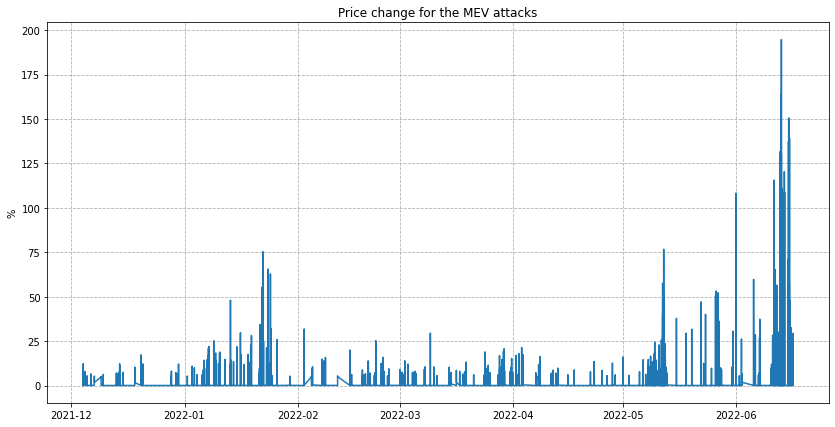

In [31]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(mevs_eth_df["time"], mevs_eth_df["price_pct"])
ax.set_ylabel("%")
ax.set_title("Price change for the MEV attacks")
ax.grid(True, linestyle='--')
plt.show()

# Writing advanced MEV extractor

Current mechanism represents adapted version of the MEV detection algorithm used for Uniswap MEV attacks detection. This mechanism groups all transactions by blocks where they were executed and searches for cases, when there are transactions with equal absolute values, but different signs

In [65]:
def extract_possible_mevs(changes_df: pd.DataFrame):
    grouped_changes_df = changes_df.groupby("timestamp")
    
    y_values = []
    tx_hashs = []
    
    for name, group in grouped_changes_df:
        if len(group) <= 2:
            continue
        
        long_changes = group[group["exchanged_position_size"] >= 0]
        short_changes = group[group["exchanged_position_size"] < 0]
        
        for index, row in long_changes.iterrows():
            if abs(row["exchanged_position_size"]) in abs(short_changes["exchanged_position_size"]).values:
                s = short_changes[abs(short_changes["exchanged_position_size"]) == abs(row["exchanged_position_size"])].iloc[0]
                
                if row["exchanged_position_size"] < s["exchanged_position_size"]:
                    y_values.append(s["exchanged_position_size"])
                    tx_hashs.append(s["tx_hash"])
                    tx_hashs.append(row["tx_hash"])
                    
        for index, row in short_changes.iterrows():
            if abs(row["exchanged_position_size"]) in abs(long_changes["exchanged_position_size"]).values:
                s = long_changes[abs(long_changes["exchanged_position_size"]) == abs(row["exchanged_position_size"])].iloc[0]
                
                if row["exchanged_position_size"] < s["exchanged_position_size"]:
                    y_values.append(s["exchanged_position_size"])
                    tx_hashs.append(s["tx_hash"])
                    tx_hashs.append(row["tx_hash"])
                    
        return changes_df[changes_df["tx_hash"].isin(tx_hashs)], tx_hashs

There is a need to check all pools at once

In [66]:
for token in position_changes_df["pool_name"].unique():
    token_changes_df = position_changes_df[position_changes_df["pool_name"] == token]
    mevs_df, tx_hashs = extract_possible_mevs(token_changes_df)
    print(token + " has " + str(len(tx_hashs)) + " transactions with possible attacks")

vBTC has 0 transactions with possible attacks
vETH has 0 transactions with possible attacks
vAVAX has 0 transactions with possible attacks
vLUNA has 0 transactions with possible attacks
vSOL has 0 transactions with possible attacks
vCRV has 0 transactions with possible attacks
vSAND has 0 transactions with possible attacks
vLINK has 0 transactions with possible attacks
vATOM has 0 transactions with possible attacks
vONE has 0 transactions with possible attacks
vNEAR has 0 transactions with possible attacks
vFTM has 0 transactions with possible attacks
vFLOW has 0 transactions with possible attacks
vBNB has 0 transactions with possible attacks
vPERP has 0 transactions with possible attacks
vMATIC has 0 transactions with possible attacks
vAAVE has 0 transactions with possible attacks
vAPE has 0 transactions with possible attacks


The standard mechanism of the MEV attacks is not working and therefore it is required to make another form of reviewing possible attacks, because of the small time window available for catching a victim and form a "Sandwich" around it. Suggestion is that there is an option for attacker to form a transaction before victim's one with drop of the price and then perform next transaction in the next block with reverse values.

In [71]:
eth_changes_df = position_changes_df[position_changes_df["pool_name"] == "vETH"]
long_eth_changes = eth_changes_df[eth_changes_df["exchanged_position_size"] >= 0]
short_eth_changes = eth_changes_df[eth_changes_df["exchanged_position_size"] < 0]

long_eth_changes[long_eth_changes["exchanged_position_size"].isin(abs(short_eth_changes["exchanged_position_size"]).values)]

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
26,0x7b4bcf49e20c5d5084f5b1bb39ff0987c845a804f64a...,0x35952141922ee99a04e016c967c3f0ad589ea958,0.500000,-2073.686083,2.075762,-2075.761845,0.000000,0.500000,4147.372165,4151.523689,4148.473824,516484004,1638003992,2021-11-27 09:06:32,vETH
29,0xa815426687d248b43eb4bd014444d40653c5f726ffbb...,0xc9735c7e0015fc9719f28306f90e530420f9b4ef,0.240678,-999.000000,1.000000,-1000.000000,0.000000,0.240678,4150.765768,4154.920688,4151.296673,516504004,1638003992,2021-11-27 09:06:32,vETH
68,0x6f9221d03728c52d1743cf521f153de4c404970e0093...,0xafa407ffd9b63783b228b671c98b943150a4336a,1.018585,-4245.750000,4.250000,-4250.000000,0.000000,1.018585,4168.283264,4172.455719,4170.544836,516809005,1638004430,2021-11-27 09:13:50,vETH
72,0x90c2ef17a3e992bdfac35e716f07710e6715a9fe04b0...,0x02cc0130ffedf077a848606b7a3e018f7f7434af,0.044581,-185.734909,0.185921,-185.920830,0.000000,0.044581,4166.204239,4170.374614,4166.303124,517202005,1638005882,2021-11-27 09:38:02,vETH
122,0x3287a20cd79cb6719ad176cac889b04ba3cc949702b3...,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf,1.000000,-4112.473944,4.116591,0.000000,47.565647,0.000000,4112.473944,0.000000,4114.643118,518481008,1638008702,2021-11-27 10:25:02,vETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370897,0x9a7a9931a96a67165053a2d961a247fb473649491400...,0xfd7b219f946087dd75fbf3630bc674f347dafeee,2.770000,-3000.092334,3.003095,-78588.580883,0.000000,72.475000,1083.065824,1084.354341,1083.272966,12160065006,1655486008,2022-06-17 17:13:28,vETH
3370906,0x7137131e2fed91f569ebabec3456eee59a2473a68d50...,0x6541e4d0f50a82544401b1e0721626415a37de99,2.767000,-2996.175453,2.999175,-62381.115760,0.000000,57.647000,1082.824522,1082.122500,1083.031371,12160122007,1655486101,2022-06-17 17:15:01,vETH
3370910,0x160f1492ef3e7903db70d22d2950e56f24536745feb9...,0xfd7b219f946087dd75fbf3630bc674f347dafeee,2.766000,-2996.236927,2.999236,-81587.817046,0.000000,75.241000,1083.238224,1084.353172,1083.445116,12160142007,1655486118,2022-06-17 17:15:18,vETH
3370938,0xac9e2d23fe9333daebf8e21b0829d5445fafd15071b5...,0xfd7b219f946087dd75fbf3630bc674f347dafeee,2.763000,-2995.964034,2.998963,-84586.780043,0.000000,78.004000,1084.315611,1084.390288,1084.523305,12160317007,1655486374,2022-06-17 17:19:34,vETH


In [73]:
short_eth_changes[abs(short_eth_changes["exchanged_position_size"]).isin(abs(long_eth_changes["exchanged_position_size"]).values)]

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
70,0xd45d92b0d237d870176e89a4813b15cc2b1647b9e429...,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf,-1.000000,4168.324506,4.168325,4164.156181,0.000000,-1.000000,4168.324506,4164.156181,4166.105357,516879005,1638004708,2021-11-27 09:18:28,vETH
75,0x6664331584ef0a92e1e33143aff7f9ce20a13086307d...,0x1313817a82545e29764281f51f6255619753235d,-1.021666,4254.254254,4.254254,4250.000000,0.000000,-1.021666,4164.038174,4159.874136,4161.774456,517284005,1638006087,2021-11-27 09:41:27,vETH
88,0x4a795e27b52d59ee77c4b7f1b789f59d4b1fd1c3ace8...,0xb23e76d88d1b41d401ec664f563fe9a2b1069795,-0.966291,4004.004004,4.004004,4000.000000,0.000000,-0.966291,4143.684136,4139.540452,4141.558758,517722005,1638006989,2021-11-27 09:56:29,vETH
160,0x37491bbecf0133ba159f4fadea48fc0fc7b011d6edfe...,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf,-1.000000,4145.688078,4.145688,0.000000,20.606873,0.000000,4145.688078,0.000000,4143.486981,519752008,1638012472,2021-11-27 11:27:52,vETH
161,0x487918f7950b0dd2d4a7fc31cf2fbe459003f2ce710b...,0xb3344d84ad8dd6b96301991bf12dc739e226c9cf,-0.011759,48.540428,0.000000,48.540428,0.000000,-0.011759,4128.043894,4128.043894,4143.486981,519810009,1638012541,2021-11-27 11:29:01,vETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370957,0x36d8749c9797b43a9854f1925d0fe333092d4dcb95df...,0x0e6fa63a19b7eb76c0e59e044b3f26618bca37b4,-8.300000,8996.258055,8.996258,8987.261797,0.000000,-8.300000,1083.886513,1082.802626,1083.263214,12160370005,1655486434,2022-06-17 17:20:34,vETH
3370964,0xe6615558b7cb32f625e02777114f8c4b3577e22672e0...,0xebd29307345ee6aec943129d9bb44120554efaac,-1.450000,1570.573876,1.570574,-91324.044544,-9.069495,83.912393,1083.154398,1088.326067,1083.045592,12160386007,1655486434,2022-06-17 17:20:34,vETH
3371004,0x3f709fcbb3eb49b4f9391f72dfc3f8d16771ae137d0c...,0xebd29307345ee6aec943129d9bb44120554efaac,-2.950000,3185.609868,3.185610,-88113.482645,-28.137640,80.962393,1079.867752,1088.326067,1079.647408,12160627007,1655486781,2022-06-17 17:26:21,vETH
3371005,0xf467e587dff7906487d6cf5263f0564ed37b93c17bc9...,0xebd29307345ee6aec943129d9bb44120554efaac,-3.040000,3281.438125,3.281438,-84804.971401,-30.354558,77.922393,1079.420436,1088.326067,1079.193511,12160632005,1655486781,2022-06-17 17:26:21,vETH


In [93]:
eth_changes_df = position_changes_df[position_changes_df["pool_name"] == "vETH"]
eth_changes_df = eth_changes_df.sort_values(by=["block_number_log_index"])
eth_changes_df = eth_changes_df.reset_index()
eth_changes_df.drop(columns=["index"], inplace=True)
eth_changes_df

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
0,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729828,-2997.000000,3.000000,-3000.000000,0.000000,0.729828,4106.445744,4110.556300,4108.035203,515571005,1638001140,2021-11-27 08:19:00,vETH
1,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.729264,-2997.000000,3.000000,-6000.000000,0.000000,1.459092,4109.624663,4112.146735,4111.214738,515584004,1638001140,2021-11-27 08:19:00,vETH
2,0x9b6ea00e0e7e7610105cf3eb2f97727c93103a9816b6...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.728700,-2997.000000,3.000000,-9000.000000,0.000000,2.187792,4112.804813,4113.737171,4114.395503,515589004,1638001140,2021-11-27 08:19:00,vETH
3,0x47357bec5ee7101b57f457be5135c91a9c7133cc82bb...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.728137,-2997.000000,3.000000,-12000.000000,0.000000,2.915928,4115.986193,4115.327606,4117.577498,515594004,1638001140,2021-11-27 08:19:00,vETH
4,0xe505626b5d32532a83c5d5bc30c7d44bb1b00f01f113...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.727574,-2997.000000,3.000000,-15000.000000,0.000000,3.643502,4119.168803,4116.918041,4120.760723,515609004,1638001140,2021-11-27 08:19:00,vETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317010,0xfce5db9fa966b4d829ff1b97a9ab48dd9c71369b22c0...,0x91d46a68324991f2e96f121317b642a8d4179190,6.249075,-6748.274038,6.755029,411625.996362,8.985862,-380.289158,1079.883745,1082.402661,1080.350665,12161025008,1655487397,2022-06-17 17:36:37,vETH
317011,0x12e03c7f9141f3b5244c766166556109aac6f79f8583...,0x91d46a68324991f2e96f121317b642a8d4179190,-4.164000,4497.284425,4.497284,416118.783502,0.000000,-384.453158,1080.039493,1082.365367,1079.728411,12161068007,1655487475,2022-06-17 17:37:55,vETH
317012,0x8a60898e97444b4a31b638910f2b035fe1b08524acbf...,0x91d46a68324991f2e96f121317b642a8d4179190,-0.000840,0.907243,0.000907,416119.689838,0.000000,-384.453998,1079.728348,1082.365359,1079.728286,12161087007,1655487490,2022-06-17 17:38:10,vETH
317013,0x103c07b0e83472c600f0279780695ace46b60a0278a7...,0x3205dbab7b8d704ed05bc72234178d61058c10ca,-3.700000,3993.972466,3.993972,5309.805821,0.000000,-4.920000,1079.452018,1079.228825,1079.175821,12161091006,1655487490,2022-06-17 17:38:10,vETH


In [112]:
tx_hashes = []

for i in range(1, len(eth_changes_df) - 1):
    prev_tx = eth_changes_df.loc[i - 1]
    cur_tx = eth_changes_df.loc[i]
    next_tx = eth_changes_df.loc[i + 1]
    
    if ((prev_tx.exchanged_position_size == -next_tx.exchanged_position_size) & 
        (prev_tx.trader == next_tx.trader) &
        ((prev_tx.realized_pnl > 0) | (next_tx.realized_pnl > 0))):
        tx_hashes.append(prev_tx.tx_hash)
        tx_hashes.append(cur_tx.tx_hash)
        tx_hashes.append(next_tx.tx_hash)
        
print(len(tx_hashes))

2382


In [113]:
possible_attacks = position_changes_df[position_changes_df["tx_hash"].isin(tx_hashes)]
possible_attacks = possible_attacks.sort_values(by='block_number_log_index')
possible_attacks

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
8483,0x5ed512af1a74e899ecd092ae319d428b5c13910849ae...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,-10.000000,40314.231893,40.314232,-8.018164e+04,183.098590,20.000000,4031.423189,4009.081907,4029.119780,852791007,1638790527,2021-12-06 11:35:27,vETH
8484,0x37b4071a9cf9e040b9b7681b9abcdcd47eb7f8c79a2e...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,2.999060,-12085.643003,12.097741,1.207130e+06,-24.187361,-299.850105,4029.810310,4025.779173,4030.500958,852869005,1638790527,2021-12-06 11:35:27,vETH
8487,0x962101d3128b726a4d966b107eb12e04b7380f99742d...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,10.000000,-40328.055523,40.368424,-1.205501e+05,0.000000,30.000000,4032.805552,4018.335403,4035.111464,853110007,1638790680,2021-12-06 11:38:00,vETH
10525,0xf954f5b233cb5bb7e842506ecc00d6bcb05affe94db1...,0x26a3e4f22f4e241dfc8987aaa3d82fab04d8e018,0.000458,-1.998000,0.002000,-2.000000e+00,0.000000,0.000458,4364.949718,4369.319037,4364.949836,954449005,1639029170,2021-12-09 05:52:50,vETH
10527,0x8228bc2d5178301d30b519ae08f67d881ff29e6049f3...,0x36209cad56c31332d575bed3e989c988c2ad8eee,20.000000,-87402.542730,87.490033,3.084168e+05,-612.067848,-71.000000,4370.127137,4343.898246,4375.310578,954534008,1639030002,2021-12-09 06:06:42,vETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287349,0x36015fb41af53f590e0fbd3ae2afc4223633419361fb...,0x8bace3a49a375027868cdd34e84521eed1f1b01d,20.000000,-22386.160963,22.408570,-8.883152e+04,0.000000,82.000000,1119.308048,1083.311269,1120.795329,11877166006,1655292933,2022-06-15 11:35:33,vETH
3287356,0x72a8223ce80fb24e5410b05457de4b9fde57acde00b9...,0x0e6fa63a19b7eb76c0e59e044b3f26618bca37b4,-8.000000,8961.599542,8.961600,8.952638e+03,0.000000,-8.000000,1120.199943,1119.079743,1119.604873,11877181004,1655292933,2022-06-15 11:35:33,vETH
3341461,0x883e7d23e5cd141cbd1ef64daf19e5918990a49699b8...,0xff058c99568e0f753b960f1d0ac7830bdff1a51a,1.000000,-1117.781579,1.118900,2.949293e+05,441.572221,-189.000000,1117.781579,1560.472700,1117.859835,12050156007,1655394482,2022-06-16 15:48:02,vETH
3341462,0x52ca866065581b2356b4e55bb97b500836405ae184a2...,0x6541e4d0f50a82544401b1e0721626415a37de99,-1.791000,2001.835958,2.001836,7.705425e+03,0.000000,-6.899000,1117.719686,1116.890151,1117.579555,12050173007,1655394497,2022-06-16 15:48:17,vETH


In [115]:
possible_attacks.head(15)

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
8483,0x5ed512af1a74e899ecd092ae319d428b5c13910849ae...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,-10.000000,40314.231893,40.314232,-8.018164e+04,183.098590,20.000000,4031.423189,4009.081907,4029.119780,852791007,1638790527,2021-12-06 11:35:27,vETH
8484,0x37b4071a9cf9e040b9b7681b9abcdcd47eb7f8c79a2e...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,2.999060,-12085.643003,12.097741,1.207130e+06,-24.187361,-299.850105,4029.810310,4025.779173,4030.500958,852869005,1638790527,2021-12-06 11:35:27,vETH
8487,0x962101d3128b726a4d966b107eb12e04b7380f99742d...,0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,10.000000,-40328.055523,40.368424,-1.205501e+05,0.000000,30.000000,4032.805552,4018.335403,4035.111464,853110007,1638790680,2021-12-06 11:38:00,vETH
10525,0xf954f5b233cb5bb7e842506ecc00d6bcb05affe94db1...,0x26a3e4f22f4e241dfc8987aaa3d82fab04d8e018,0.000458,-1.998000,0.002000,-2.000000e+00,0.000000,0.000458,4364.949718,4369.319037,4364.949836,954449005,1639029170,2021-12-09 05:52:50,vETH
10527,0x8228bc2d5178301d30b519ae08f67d881ff29e6049f3...,0x36209cad56c31332d575bed3e989c988c2ad8eee,20.000000,-87402.542730,87.490033,3.084168e+05,-612.067848,-71.000000,4370.127137,4343.898246,4375.310578,954534008,1639030002,2021-12-09 06:06:42,vETH
10528,0xe04c4ee0e69a945361970f31acfb04515e6cdb3b5d06...,0x26a3e4f22f4e241dfc8987aaa3d82fab04d8e018,-0.000458,2.002742,0.002003,0.000000e+00,0.000740,0.000000,4375.310459,0.000000,4375.310340,954655008,1639030350,2021-12-09 06:12:30,vETH
12377,0x5deac595a151221acc55edc08e2d8555c971b69e0ccb...,0x9219216fa5977a5b7951c20fe21a0d288675cdb6,-10.000000,39159.107961,39.159108,7.889567e+04,0.000000,-20.000000,3915.910796,3944.783592,3913.815304,1027299006,1639179644,2021-12-10 23:40:44,vETH
12382,0x1e00035563677a855f7f88c35948adfd1c508cef0cff...,0x1d16ea2b8bfcf5f7c13c1ea792d6c6a7a9aa1063,2.276992,-8912.810882,8.921733,0.000000e+00,57.531763,0.000000,3914.292248,0.000000,3914.769251,1027499008,1639180046,2021-12-10 23:47:26,vETH
12384,0xab4fbf5350627d7782e6844d2c70a8973eb9c036147b...,0x9219216fa5977a5b7951c20fe21a0d288675cdb6,10.000000,-39168.655098,39.207863,3.944784e+04,239.972964,-10.000000,3916.865510,3944.783592,3918.962891,1027561007,1639180046,2021-12-10 23:47:26,vETH
16664,0x9fd8deab1bf762cb94526a81eea7a3450fa68a02eaa0...,0x9219216fa5977a5b7951c20fe21a0d288675cdb6,-10.000000,39589.712487,39.589712,-7.902235e+04,38.948571,20.000000,3958.971249,3951.117420,3956.783422,1223581008,1639596743,2021-12-15 19:32:23,vETH


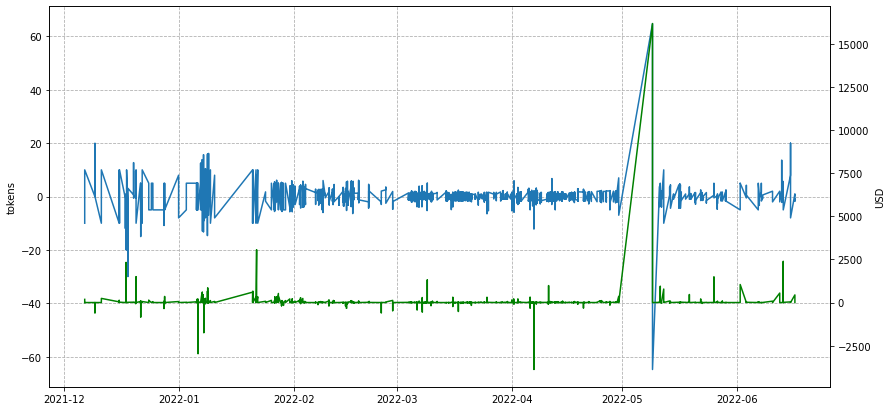

In [114]:
fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()

ax.plot(possible_attacks["time"], possible_attacks["exchanged_position_size"])
ax2.plot(possible_attacks["time"], possible_attacks["realized_pnl"], color='g')

ax.set_ylabel("tokens")
ax2.set_ylabel("USD")
ax.grid(True, linestyle='--')
plt.show()

Application of the modified algorithms for searching the attacks demonstrated that there are no transactions that have a MEV-like behavior:

1. There are transactions with reverse values and the same address that performed transactions (looking like a base MEV attack concept), but there are different blocks where those transactions were executed;
2. Even when there are transactions with reverse values can be seen that there are already hold tokens for the specific position and therefore it looks more like playing with the position to minimize losses or extract higher profits;
3. In most of the cases it does not lead to getting profit out of manipulations, because all profits would be catches by the ```realized_pnl``` while in the presented cases there are more losses than profits.

To ensure this below are shown results of finding MEV attacks also for BTC, CRV and PERP tokens

In [118]:
btc_changes_df = position_changes_df[position_changes_df["pool_name"] == "vBTC"]
btc_changes_df = btc_changes_df.sort_values(by=["block_number_log_index"])
btc_changes_df = btc_changes_df.reset_index()
btc_changes_df.drop(columns=["index"], inplace=True)

tx_hashes = []

for i in range(1, len(btc_changes_df) - 1):
    prev_tx = btc_changes_df.loc[i - 1]
    cur_tx = btc_changes_df.loc[i]
    next_tx = btc_changes_df.loc[i + 1]
    
    if ((prev_tx.exchanged_position_size == -next_tx.exchanged_position_size) & 
        (prev_tx.trader == next_tx.trader) &
        ((prev_tx.realized_pnl > 0) | (next_tx.realized_pnl > 0))):
        tx_hashes.append(prev_tx.tx_hash)
        tx_hashes.append(cur_tx.tx_hash)
        tx_hashes.append(next_tx.tx_hash)
        
print(len(tx_hashes))
possible_attacks = position_changes_df[position_changes_df["tx_hash"].isin(tx_hashes)]

1188


In [120]:
possible_attacks

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
12405,0xddacc99b29d07d29be182f8ba09b59dbd7580d4c976f...,0x1d16ea2b8bfcf5f7c13c1ea792d6c6a7a9aa1063,-0.063543,3003.003003,3.003003,3.000000e+03,0.000000,-0.063543,47259.254915,47211.995660,47257.207073,1028228004,1639180556,2021-12-10 23:55:56,vBTC
12406,0x4d6c898c59c3734de19471970e1e0a3d99dc933cbfbd...,0xa2600926786e9c2e1fa4b4a1118ddf0bfe1e7f91,-1.500000,70813.375844,70.813376,7.074256e+04,0.000000,-1.500000,47208.917229,47161.708312,47160.676730,1028289005,1639180905,2021-12-11 00:01:45,vBTC
12408,0x8da0751821bbdcec3f68417f8ff6b36fbd94b24cae44...,0x1d16ea2b8bfcf5f7c13c1ea792d6c6a7a9aa1063,0.063543,-2996.868760,2.999869,0.000000e+00,0.131371,0.000000,47162.718300,0.000000,47164.759958,1028403007,1639180905,2021-12-11 00:01:45,vBTC
14356,0x6b56362dd78f15c75293ecec734c1f805b6c63f4c044...,0xa2600926786e9c2e1fa4b4a1118ddf0bfe1e7f91,-1.000000,47593.697552,47.593698,1.934224e+05,0.000000,-4.000000,47593.697552,48355.594082,47562.468047,1118070006,1639408506,2021-12-13 15:15:06,vBTC
14360,0xadbab571b7aab5cb0eb6754e9095b40e4a41b3eb0fd4...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.144810,-6888.197745,6.895093,1.128316e+06,95.307718,-23.373755,47566.987868,48272.757364,47571.508119,1118277008,1639408571,2021-12-13 15:16:11,vBTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341285,0xb672d1b3fcd7cc2ed741dd829720f3f14cce2ef20883...,0x6541e4d0f50a82544401b1e0721626415a37de99,0.093800,-1997.107315,1.999106,-1.116085e+04,0.000000,0.511200,21291.122764,21832.653841,21326.859318,12049365006,1655394002,2022-06-16 15:40:02,vBTC
3341296,0xeff178c002eaaa1638397ee6b69a594a59ed665144b8...,0x8fb5c6f3c336033deeedbb54ad95e96453c9eaa4,-0.050000,1065.390846,1.065391,0.000000e+00,1.455226,0.000000,21307.816926,0.000000,21288.791536,12049423008,1655394032,2022-06-16 15:40:32,vBTC
3349404,0xd4cc750f5efdc7da636d9799b0af636c56ff8b6a4933...,0x8fb5c6f3c336033deeedbb54ad95e96453c9eaa4,0.050000,-1021.464126,1.022487,0.000000e+00,3.098206,0.000000,20429.282520,0.000000,20447.496694,12081308008,1655420180,2022-06-16 22:56:20,vBTC
3349416,0x119c76525541485a408bb80f478d3675d671581a6bcd...,0xfd6472cfa873b0a165607b366f83aeed57f37b1d,-0.020000,408.804143,0.408804,1.205900e+03,0.000000,-0.050000,20440.207128,24117.993742,20432.920161,12081407007,1655420289,2022-06-16 22:58:09,vBTC


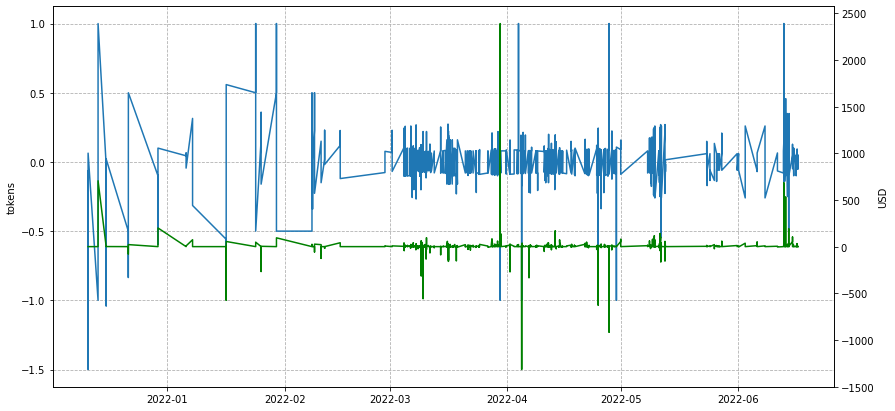

In [119]:
fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()

ax.plot(possible_attacks["time"], possible_attacks["exchanged_position_size"])
ax2.plot(possible_attacks["time"], possible_attacks["realized_pnl"], color='g')

ax.set_ylabel("tokens")
ax2.set_ylabel("USD")
ax.grid(True, linestyle='--')
plt.show()

In [121]:
crv_changes_df = position_changes_df[position_changes_df["pool_name"] == "vCRV"]
crv_changes_df = crv_changes_df.sort_values(by=["block_number_log_index"])
crv_changes_df = crv_changes_df.reset_index()
crv_changes_df.drop(columns=["index"], inplace=True)

tx_hashes = []

for i in range(1, len(crv_changes_df) - 1):
    prev_tx = crv_changes_df.loc[i - 1]
    cur_tx = crv_changes_df.loc[i]
    next_tx = crv_changes_df.loc[i + 1]
    
    if ((prev_tx.exchanged_position_size == -next_tx.exchanged_position_size) & 
        (prev_tx.trader == next_tx.trader) &
        ((prev_tx.realized_pnl > 0) | (next_tx.realized_pnl > 0))):
        tx_hashes.append(prev_tx.tx_hash)
        tx_hashes.append(cur_tx.tx_hash)
        tx_hashes.append(next_tx.tx_hash)
        
print(len(tx_hashes))
possible_attacks = position_changes_df[position_changes_df["tx_hash"].isin(tx_hashes)]

3954


In [122]:
possible_attacks

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
174626,0xc69185924dcc3c095318d8f38f36d9b26697092ad8fe...,0x1b1988e307a7b59d9008cca54be442049963fe48,-3800.000000,10655.086113,10.655086,32138.756722,0.000000,-11400.000000,2.803970,2.819189,2.801849,2908598007,1643308239,2022-01-27 18:30:39,vCRV
174628,0xaf3f95e162bc23b8bbd08434e8fe5645fc8231edff16...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-4111.903621,11511.511512,11.511512,-159114.455947,-275.777099,55560.096125,2.799558,2.863826,2.797268,2908601007,1643308239,2022-01-27 18:30:39,vCRV
174631,0xaa3e7970d6eb912844ae793bb2783590c46f69171c16...,0x1b1988e307a7b59d9008cca54be442049963fe48,3800.000000,-10637.658882,10.648307,21425.837814,64.611718,-7600.000000,2.799384,2.819189,2.801501,2908606005,1643308239,2022-01-27 18:30:39,vCRV
175162,0x16d0633f0d32af49a2aa82419fe655908e5ba72624ba...,0x1b1988e307a7b59d9008cca54be442049963fe48,3800.000000,-10558.669723,10.569239,21498.391310,179.956693,-7600.000000,2.778597,2.828736,2.780691,2910692005,1643311873,2022-01-27 19:31:13,vCRV
175169,0xda0531b5407f66fff0521f9033a465a7051b48303f9b...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,3590.074468,-9990.000000,10.000000,-122072.780849,0.000000,42995.440259,2.782672,2.839203,2.784655,2910711004,1643311873,2022-01-27 19:31:13,vCRV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350125,0xe32b3912667db923f62fd5e6fa9a7a63a5942405eea1...,0x57944fba39b44189f7173e70cf9ed99f2395283a,2290.673807,-1499.745472,1.501247,66053.833878,39.187368,-98224.123000,0.654718,0.672481,0.655257,12083982008,1655422278,2022-06-16 23:31:18,vCRV
3350126,0x3c3015a9948441c04b225c0b5946d18bf4a76abc087a...,0xdf4b3f4a4ebd640b61c187e2e499c76e0504ebfd,2000.000000,-1311.457070,1.312770,-656.384920,-2.389927,1000.000000,0.655729,0.656385,0.656200,12083983007,1655422278,2022-06-16 23:31:18,vCRV
3369675,0x72a65d6b1a62bd8640ee6b0a47d167291349ebe474d0...,0xd94606128b20680539a719b07bca6cbc30786a28,-1518.000000,1008.369505,1.008370,1007.361135,0.000000,-1518.000000,0.664275,0.663611,0.663370,12154491005,1655480279,2022-06-17 15:37:59,vCRV
3369676,0xa8fce814da1f0ca1b2374d3864dec877ee412b5666ba...,0x57944fba39b44189f7173e70cf9ed99f2395283a,-1132.823333,750.717580,0.750718,50437.804428,0.000000,-75107.016035,0.662696,0.671546,0.662023,12154492007,1655480294,2022-06-17 15:38:14,vCRV


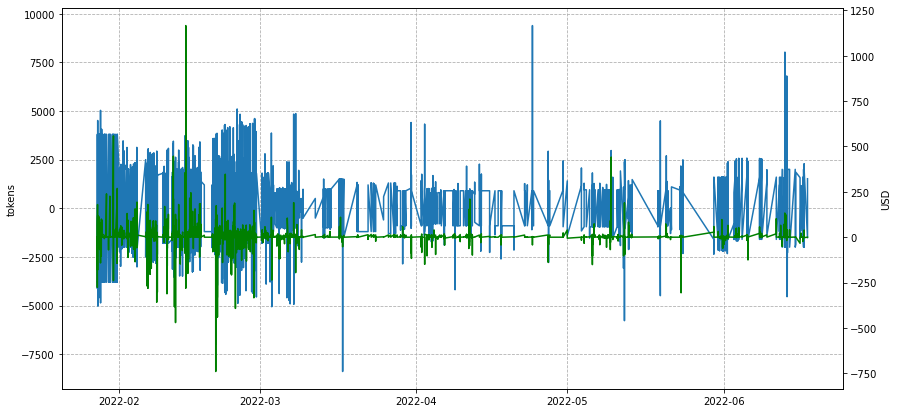

In [123]:
fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()

ax.plot(possible_attacks["time"], possible_attacks["exchanged_position_size"])
ax2.plot(possible_attacks["time"], possible_attacks["realized_pnl"], color='g')

ax.set_ylabel("tokens")
ax2.set_ylabel("USD")
ax.grid(True, linestyle='--')
plt.show()

In [124]:
perp_changes_df = position_changes_df[position_changes_df["pool_name"] == "vPERP"]
perp_changes_df = perp_changes_df.sort_values(by=["block_number_log_index"])
perp_changes_df = perp_changes_df.reset_index()
perp_changes_df.drop(columns=["index"], inplace=True)

tx_hashes = []

for i in range(1, len(perp_changes_df) - 1):
    prev_tx = perp_changes_df.loc[i - 1]
    cur_tx = perp_changes_df.loc[i]
    next_tx = perp_changes_df.loc[i + 1]
    
    if ((prev_tx.exchanged_position_size == -next_tx.exchanged_position_size) & 
        (prev_tx.trader == next_tx.trader) &
        ((prev_tx.realized_pnl > 0) | (next_tx.realized_pnl > 0))):
        tx_hashes.append(prev_tx.tx_hash)
        tx_hashes.append(cur_tx.tx_hash)
        tx_hashes.append(next_tx.tx_hash)
        
print(len(tx_hashes))
possible_attacks = position_changes_df[position_changes_df["tx_hash"].isin(tx_hashes)]

921


In [125]:
possible_attacks

,tx_hash,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,block_number_log_index,timestamp,time,pool_name
978854,0x84f7587c794dd7609c717d545e59a65cf7f2ca58c39a...,0xbcb57a1e86127cf3e7a88a05bc9052932974f19d,-900.000000,4188.639297,4.188639,0.000000,20.178774,0.000000,4.654044,0.000000,4.652547,4814001007,1648159938,2022-03-24 22:12:18,vPERP
978856,0xb36d9598cd51523cba7472bc51322225288045d070a3...,0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca,140.921647,-655.677608,0.656334,-20314.773138,0.000000,4381.284295,4.652781,4.636716,4.653016,4814003007,1648159953,2022-03-24 22:12:33,vPERP
978858,0x8c13f39170c865671ab5b9f5ea27922f8ab7aa4be5fd...,0xbcb57a1e86127cf3e7a88a05bc9052932974f19d,900.000000,-4189.061202,4.193254,-4193.254456,0.000000,900.000000,4.654512,4.659172,4.656010,4814008004,1648159953,2022-03-24 22:12:33,vPERP
979297,0x949f3569a0a61c3a77bf390701e078550db8daa66f85...,0xbcb57a1e86127cf3e7a88a05bc9052932974f19d,-900.000000,4239.472382,4.239472,0.000000,12.892075,0.000000,4.710525,0.000000,4.709051,4814770008,1648162175,2022-03-24 22:49:35,vPERP
979298,0x7a589004a712f32d9cf47daf9209b1b3c474fca9ca09...,0xbcb57a1e86127cf3e7a88a05bc9052932974f19d,-900.000000,4236.820543,4.236821,4232.583722,0.000000,-900.000000,4.707578,4.702871,4.706106,4814772005,1648162193,2022-03-24 22:49:53,vPERP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3358775,0x1cc817cf3cbbe45997bd8855066415687c357f106318...,0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be,-2563.390531,1501.501502,1.501502,156000.238279,0.000000,-255294.049685,0.585748,0.611061,0.584759,12112557006,1655446723,2022-06-17 06:18:43,vPERP
3358776,0x1c628ec0454c491261d8da5c8db982aa5d65bd7e9329...,0x8fb5c6f3c336033deeedbb54ad95e96453c9eaa4,1802.000000,-1054.988340,1.056044,0.000000,1.459234,0.000000,0.585454,0.000000,0.586150,12112559005,1655446723,2022-06-17 06:18:43,vPERP
3360892,0x9f2b0b9319365196122423f7d736a0df884d46a0bc9a...,0x0d311f7d6641345a321065b7e6f1b8e4d4a48dd9,-2350.900000,1433.947337,1.433947,-1971.739871,3.081029,3242.800000,0.609957,0.608036,0.608193,12119035007,1655451662,2022-06-17 07:41:02,vPERP
3360895,0xa1d0088fdd3bc59da796200ca9fb501fdf519703bff6...,0x0d311f7d6641345a321065b7e6f1b8e4d4a48dd9,-2542.500000,1541.507748,1.541508,-425.807768,-5.965862,700.300000,0.606296,0.608036,0.604405,12119040005,1655451662,2022-06-17 07:41:02,vPERP


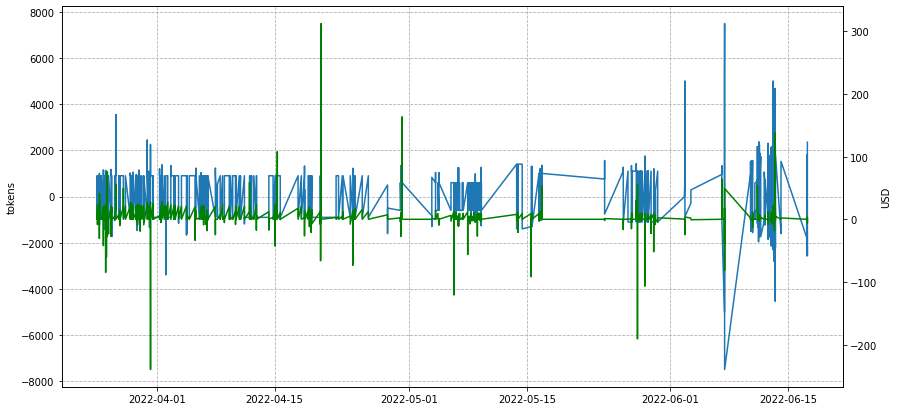

In [126]:
fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()

ax.plot(possible_attacks["time"], possible_attacks["exchanged_position_size"])
ax2.plot(possible_attacks["time"], possible_attacks["realized_pnl"], color='g')

ax.set_ylabel("tokens")
ax2.set_ylabel("USD")
ax.grid(True, linestyle='--')
plt.show()

Even in the unique cases when there was registered a behavior similar to the MEV attacks (the same address, the same block, the same absolute values of applied position changes) can be seen that there are a very small profits extracted out of the applied changes. More interesting aspect is that it additionally demonstrates concept of performing changes conform price changes to minimize losses or maximize profits via performing small changes that will extract profits.

Therefore, it is important to consider that there is an option of performing attacks on the vAMMs, but there are no registered big cases of such attacks. To perform those attacks efficiently it is required to solve problems mentioned above which will be extremely complicated and it will be more profitable to write a bot performing trades on such a platform.